# Neural Networks exam project: Greedy Multimodal Learning
### Notebook used for model training, evaluation and testing
Ludovico Comito Matr. 1837155, Giulio Fedeli Matr. 1873677

## Introduction

The following exam projects replicates and re-implements the experiment presented in the paper [_"Characterizing and Overcoming the Greedy Nature of Learning in Multi-modal Deep Neural Networks"_](https://arxiv.org/pdf/2202.05306.pdf) by Wu et al. <br> This paper presents the hypothesis that multi-modal deep neural networks tend to rely one modality, which is the fastest one to learn from. This hyptohesis is proven empirically by defining specific metrics for assessing learning speeds and proposes a balancing algorithm to address greedy learning.
<br> Our work implements this experiment in Pytorch, by leveraging the Pytorch Lightning framework to handle training.

## GDrive and Imports

In [1]:
!pip install lightning wandb --quiet

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
from pytorch_lightning.loggers import CSVLogger


import pandas as pd
import numpy as np
import os
import pickle
import wandb
import csv

import torchvision.models as models

/Users/ludocomito/Desktop/Università/AIRO/nn_project/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Identify correct devide
if torch.backends.mps.is_available():
    dev = "mps"
elif torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"

device = torch.device(dev)
print(device)

mps


### Parameters definition

In [4]:
parameters_dict = {
    # Logging
    'experiment_name': 'balanced_model',
    'checkpoint_dir': '/Users/ludocomito/Desktop/Project/greadiness_project/checkpoints/balanced_model',
    'logging_dir': '/Users/ludocomito/Desktop/Project/greadiness_project/logging/balanced_model',

    # Dataset npy files
    'make_npy_files': False, # if True, creates npy files for the dataset. Do it just the first time.

    # Model
    'pretraining': False, # if True, uses pretrained weights for the resnet18 modules.
    'num_views': 2, 
    'debug_mode': True, # if True enables wandb logging and model checkpointing

    # Train configuration
    'batch_size': 8,
    'lr': 0.1,
    'wd': 0.0,
    'momentum': 0.0,
    'monitor': 'acc',
    'epsilon': 0.01, # the imbalance tolerance parameter. If |delta_cls|>epsilon, then trigger balancing step.
    'curation_windowsize': 5, # for how many steps to repeat the balancing step.
    'starting_epoch': 2,  # the epoch on which to start the balanced training.
    'branchnames': ['net_view_0', 'net_view_1'],
    'MMTMnames': ['m0', 'm1'],


    # Training loop
    'nummodalities': 2,
    'n_epochs': 100,
    'use_gpu': True,
    'checkpoint_monitor': 'val_acc',

    # Dataset
    'make_npy_files': False,
    'num_views': 2,
    'num_workers': 0,
    'specific_views': [0, 6], # specify the views (modalities) you want to load. If [0, 0], loads the same view twice.

}

In [5]:
if not parameters_dict['debug_mode']:
    wandb.init(
        # set the wandb project where this run will be logged
        project='greedy_learning',
        name=parameters_dict['experiment_name'],
        # track hyperparameters and run metadata
        config=parameters_dict,
        entity='greediness-team'
    )

### CSV Logging

In [6]:
# training logs are written to a csv file
csv_logger = CSVLogger(save_dir=parameters_dict['logging_dir'], name=(parameters_dict['experiment_name'] + '_LOG'))

## Dataset

In [7]:
import glob
import torch.utils.data
import os
import math
import pandas as pd
from skimage import io, transform, util
from PIL import Image
import torch
import torchvision as vision
from torchvision import transforms, datasets
import random
import copy
import numpy as np

import timeit

In [8]:
# Fixed seed for reproducibility
SEED_FIXED = 100000

def load_modelviews(files):
    '''
    Reads images from files using the PIL library and returns a numpy tensor of rgb images.
    '''
    imgs = []
    for f in files:
        im = np.array(Image.open(f).convert('RGB'))
        imgs.append(im)
    return np.stack(imgs)
            
def load_modelinto_numpy(root_dir, classnames, ending='/*.png'):
    '''
    Stores data as numpy arrays for faster loading.
    '''
    set_ = root_dir.split('/')[-1]
    parent_dir = root_dir.rsplit('/',2)[0]
    
    for i in range(len(classnames)):
        all_files = sorted(glob.glob(parent_dir+'/'+classnames[i]+'/'+set_+ending))
        
        nummodels = int(len(all_files)/12)
        print('Transforming %d models of class %d - %s into tensor'%(nummodels, i, classnames[i]))
        starting_time = timeit.default_timer()
        
        for m_ind in range(nummodels):
            modelimgs = load_modelviews(all_files[m_ind*12:m_ind*12+12])
            with open(all_files[m_ind*12].rsplit('.',2)[0]+'.npy', 'wb') as f:
                torch.save(modelimgs, f)
        
        print('... finished in %.2fs'%(timeit.default_timer() - starting_time))

In [9]:
class MultiviewModelDataset(torch.utils.data.Dataset):
    '''
    Dataset class for the multiview model dataset.
    '''
    def __init__(self, root_dir, ending='/*.png',
                 num_views=12, shuffle=True, specific_view=None, transform=None):

        self.classnames=['airplane','bathtub', 'bed','bench','bookshelf','bottle','bowl','car','chair',
                         'cone','cup','curtain','desk','door','dresser','flower_pot','glass_box',
                         'guitar','keyboard','lamp','laptop','mantel','monitor','night_stand',
                         'person','piano','plant','radio','range_hood','sink','sofa','stairs',
                         'stool','table','tent','toilet','tv_stand','vase','wardrobe','xbox']
        self.root_dir = root_dir
        
        self.num_views = num_views
        self.specific_view = specific_view

        self.transform = transform
        self.init_filepaths(ending)

    def init_filepaths(self, ending):
        '''
        Creates a list of filepaths for all models in the dataset and stores it in self.filepaths.
        '''
        self.filepaths = []
        for i in range(len(self.classnames)):
            all_files = sorted(glob.glob(self.root_dir.rsplit('/',2)[0]+'/'+self.classnames[i]+'/'+self.root_dir.split('/')[-1]+ending))
            files = [] 
            for file in all_files:
                files.append(file.split('.obj.')[0])
                
            files = list(np.unique(np.array(files)))
            self.filepaths.extend(files)
    
    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        '''
        Creates image tensor and returns it together with the class id.
        '''
        path = self.filepaths[idx]
        class_name = path.split('/')[-3]
        class_id = self.classnames.index(class_name)
        imgs = torch.load(path+'.obj.npy')
        trans_imgs = []
        for img, view in zip(imgs[self.specific_view], self.specific_view):
            if self.transform:
                img = self.transform(img)
            trans_imgs.append(img) 
        data = torch.stack(trans_imgs)
        return idx, data, class_id

In [10]:
def create_dataloaders(
        ending = '/*.png',
        root_dir = '/Users/ludocomito/Desktop/Project/Datasets/modelnet40_images_new_12x', 
        make_npy_files = False,
        valid_size=0.2,
        batch_size=8,
        random_seed_for_validation = 10,
        num_views=12,
        num_workers=0,
        specific_views=parameters_dict['specific_views'],
        seed=777,
        use_cuda=True,
        ):
    
    '''
    Initalizes datasets and dataloaders for training, validation and testing.
    '''
    random.seed(seed)
    np.random.seed(seed) 
    torch.manual_seed(seed) 
    if use_cuda: torch.cuda.manual_seed_all(seed)
    
    test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ]) 

    if make_npy_files:
        classnames =['airplane','bathtub', 'bed','bench','bookshelf','bottle','bowl','car','chair',
                         'cone','cup','curtain','desk','door','dresser','flower_pot','glass_box',
                         'guitar','keyboard','lamp','laptop','mantel','monitor','night_stand',
                         'person','piano','plant','radio','range_hood','sink','sofa','stairs',
                         'stool','table','tent','toilet','tv_stand','vase','wardrobe','xbox']

        load_modelinto_numpy(os.path.join(root_dir, '*/test'), classnames, ending='/*.png', numviews = 12)
        load_modelinto_numpy(os.path.join(root_dir, '*/train'), classnames, ending='/*.png', numviews = 12)

    # transforms pipeline for training data
    train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    test_dataset = MultiviewModelDataset(os.path.join(root_dir, '*', 'test'),
        ending=ending,
        num_views=num_views, 
        specific_view=specific_views, 
        transform=test_transform)

    test_loader = torch.utils.data.DataLoader(test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers)

    training = MultiviewModelDataset(os.path.join(root_dir, '*', 'train'), 
        ending=ending, 
        num_views=num_views, 
        specific_view=specific_views, 
        transform=train_transform)

    num_train = len(training)
    indices = list(range(num_train))
    training_idx = indices

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg
    
    split = int(np.floor(valid_size * num_train))
    random.Random(random_seed_for_validation).shuffle(indices)
    training_idx, valid_idx = indices[split:], indices[:split]
    
    valid_sub = torch.utils.data.Subset(training, valid_idx)
    valid_loader = torch.utils.data.DataLoader(valid_sub,
                       batch_size=batch_size,
                       shuffle=False,
                       num_workers=num_workers,
                       ) 

    training_sub = torch.utils.data.Subset(training, training_idx)

    training_loader = torch.utils.data.DataLoader(training_sub,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers,
                                                   ) 
    
    return training_loader, valid_loader, test_loader

The below cell creates npy files for the dataset, and this step is needed just the first time. Once the cell finishes the execution, change the _make_npy_files_ in parameters_dict to False and run all cells from the beginning.

In [11]:
if parameters_dict['make_npy_files']:
    _, _, _ = create_dataloaders(make_npy_files=parameters_dict['make_npy_files'])

## Datamodule
Pytorch Lightning class to handle datasets during training, testing and validation steps.

In [12]:
class ModelnetDataModule(pl.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()

        self.batch_size = batch_size

    def setup(self, stage: str):
        training_loader, valid_loader, test_loader = create_dataloaders(batch_size=self.batch_size)
        self.training_loader = training_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader

    def train_dataloader(self):
        return self.training_loader

    def val_dataloader(self):
        return self.valid_loader

    def test_dataloader(self):
        return self.test_loader

In [13]:
datamodule = ModelnetDataModule(batch_size=parameters_dict['batch_size'])

## Model definition

In this experiment, modalities are fused by following the methodology defined in the paper [_"MMTM: Multimodal Transfer Module for CNN Fusion"_](https://arxiv.org/pdf/1911.08670.pdf). The paper leverages the notion of intermediate fusion by using information from different modalities to recalibrate channel-wise features in each modality. <br>
The following image shows the illustrates the MMTM mechanism: <br>

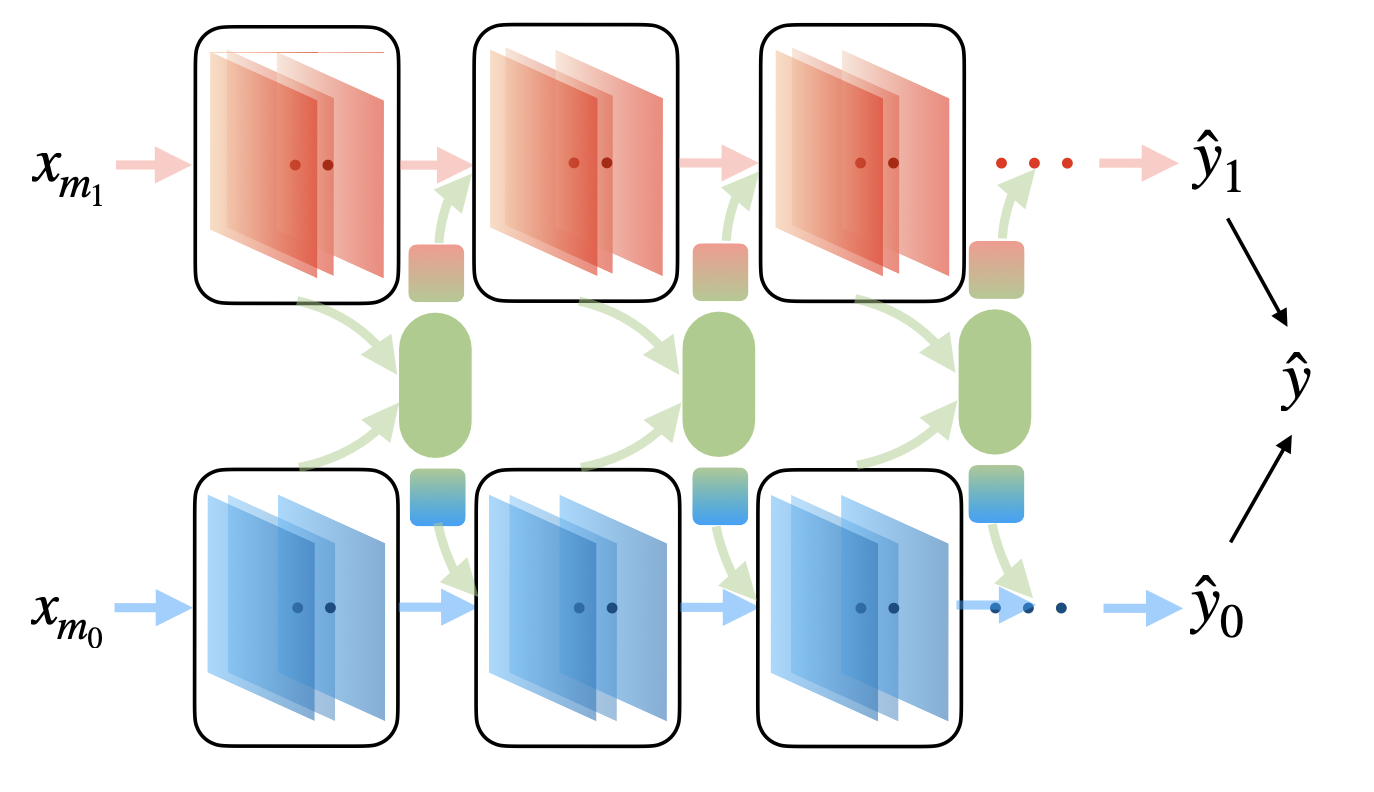 

Following the paper's experiment, we use the original MMTM architecture, but implementing the balancing algorithm in the forward step. In short, we check if the model needs to perform a balancing step by checking if the variable _curation\_mode_ is True (if it's False, we take a regular step). <br>
When a balancing step is needed, the branch with the slowest learning speed is accelerated, by rescaling it's feature maps differently from the faster branch. For example, if we need to accelerate learning from $m_0$, then we will compute the new features as follows:
$$
\bold{\tilde{A}_0}=2\times \sigma(\bar{w}_0) \odot \bold{A_0}
$$

$$
\bold{\tilde{A}_1}=2\times \sigma(w_1) \odot \bold{A_1}
$$

Where $ \bar{w}_0 = \frac{1}{n_t}\sum_{i=1}^{n_t}w_0(x^i) $


_But why does this work in the first place?_

This technique is based on the intuition and results achieved by the papers:

- [L2 Regularization versus Batch and Weight Normalization](https://arxiv.org/pdf/1706.05350.pdf)
- [Three Mechanism of Weight Decay Regularization](https://arxiv.org/pdf/1810.12281.pdf)
- [High-performance large-scale image recognition without normalization](https://arxiv.org/pdf/2102.06171.pdf)

The key idea is that changing the scale of weights actually changes the effective learning rate during the update. In particular, reducing the scale of weights will increase the effective learning rate, and vice-versa. The fundamental reasoning is the following:

During a regular SGD, the update step looks like:

$$
w_{t+1}\larr w_t-\eta \Delta L_\lambda (w_t)
$$

Where $\eta$  represents the learning rate.

Now let’s imagine that $w_t=\alpha w'_t$. Then, we can write the SGD update as

$$
\alpha w_t' \leftarrow \alpha w_t' - \eta/\alpha \Delta L_{\lambda \alpha^2}(w_t')
$$

But this is just an SGD update of $w'$ with a different learning rate, and a different amount of regularization:

$$
w' \larr w' - \eta /\alpha^2 \Delta L_{\lambda \alpha^2}(w')
$$


In [14]:
class MMTM(nn.Module):
    def __init__(self,
                 dim_m0,
                 dim_m1,
                 ratio):
        super(MMTM, self).__init__()
        
        dim = dim_m0 + dim_m1
        dim_out = int(2*dim/ratio)


        self.running_avg_weight_m0 = torch.zeros(dim_m0)
        self.running_avg_weight_m1 = torch.zeros(dim_m0)
        self.step = 0

        self.fc_squeeze = nn.Linear(dim, dim_out)


        self.fc_m0 = nn.Linear(dim_out, dim_m0)
        self.fc_m1 = nn.Linear(dim_out, dim_m1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self,
                m0,
                m1,
                curation_mode=False,
                caring_modality=0):


        squeeze_array = []
        for tensor in [m0, m1]:
            tview = tensor.view(tensor.shape[:2] + (-1,))
            squeeze_array.append(torch.mean(tview, dim=-1))

        squeeze = torch.cat(squeeze_array, 1)
        excitation = self.fc_squeeze(squeeze)
        excitation = self.relu(excitation)

        vis_out = self.fc_m0(excitation)
        sk_out = self.fc_m1(excitation)

        vis_out = self.sigmoid(vis_out)
        sk_out = self.sigmoid(sk_out)

        current_device = vis_out.device

        self.running_avg_weight_m0 = (vis_out.mean(0) + 
                                      self.running_avg_weight_m0.to(current_device)*self.step).detach()/(self.step+1)
        
        self.running_avg_weight_m1 = (vis_out.mean(0) + 
                                      self.running_avg_weight_m1.to(current_device)*self.step).detach()/(self.step+1)

        self.step += 1


        scales = None

        squeeze_array = None

        if not curation_mode:  # regular step, just like MMTM
            dim_diff = len(m0.shape) - len(vis_out.shape)
            vis_out = vis_out.view(vis_out.shape + (1,) * dim_diff)

            dim_diff = len(m1.shape) - len(sk_out.shape)
            sk_out = sk_out.view(sk_out.shape + (1,) * dim_diff)

        else:  # balancing step
            # accelerate learning from m1 (because BDR0 > BDR1 in the current step)
            if caring_modality == 0:
                # print("I have to accelerate m1")
                dim_diff = len(m1.shape) - len(sk_out.shape)
                sk_out = sk_out.view(sk_out.shape + (1,) * dim_diff)

                dim_diff = len(m0.shape) - len(vis_out.shape)
                vis_out = torch.stack(vis_out.shape[0]*[self.running_avg_weight_m0]).view(vis_out.shape + (1,) * dim_diff)

            # accelerate learning from m1 (because BDR1 > BDR0 in the current step)
            elif caring_modality == 1:
                # print("I have to accelerate m0")
                dim_diff = len(m0.shape) - len(vis_out.shape)
                vis_out = vis_out.view(vis_out.shape + (1,) * dim_diff)

                dim_diff = len(m1.shape) - len(sk_out.shape)
                sk_out = torch.stack(sk_out.shape[0]*[self.running_avg_weight_m1]).view(sk_out.shape + (1,) * dim_diff)

        return m0 * vis_out, m1 * sk_out, scales, squeeze_array

### Main model

The class MMTM_MVCNN implements the full architecture for this experiment. Following the paper, each of the two branches implements a ResNet18 as an encoder for the input image. After being encoded, the information for each branch is fused within the MMTM module and then passed to the next layer. The image before is a visualization of the operations perfomed for each layer:

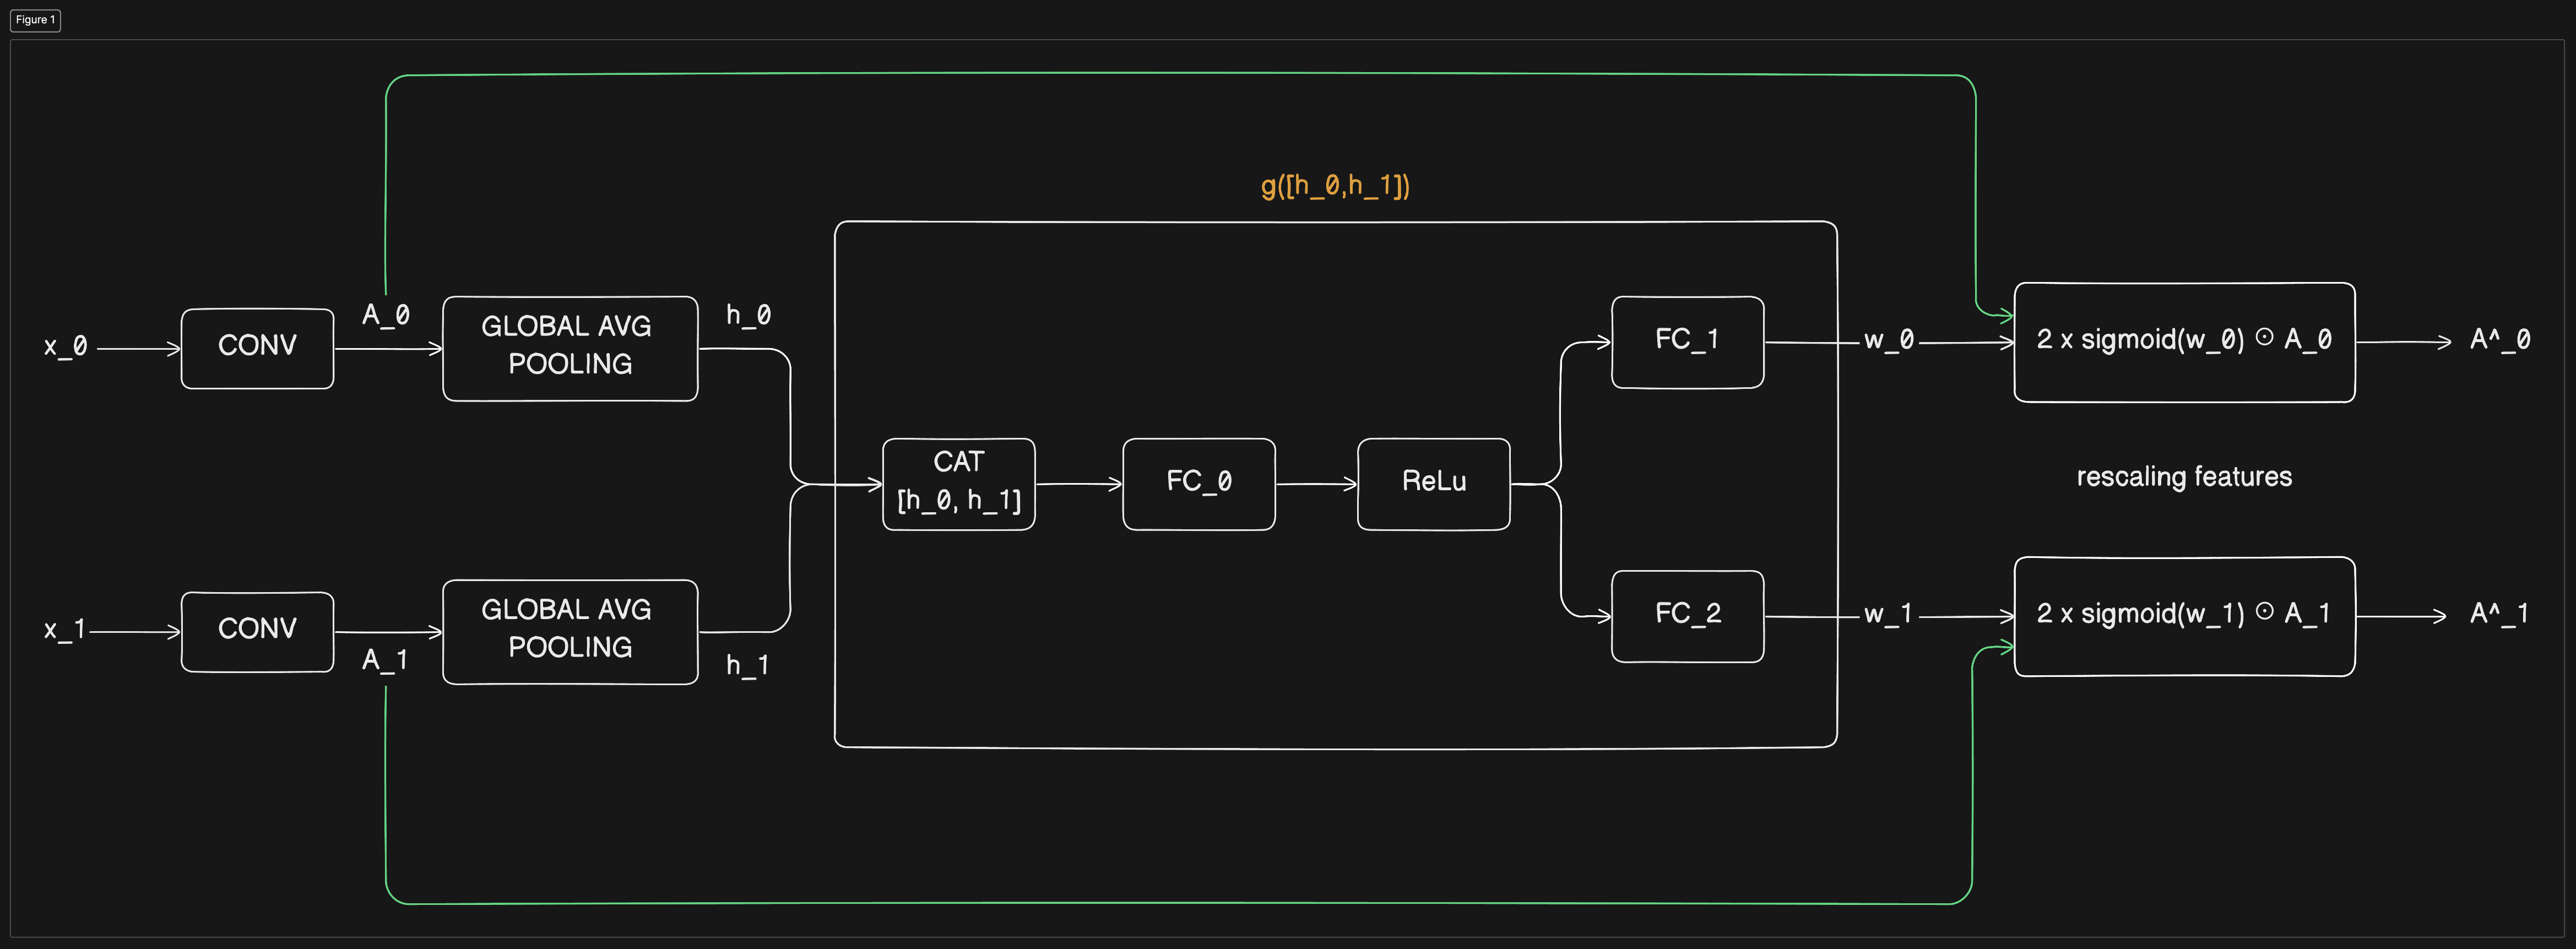

In [15]:
class MMTM_MVCNN(nn.Module):
    def __init__(self,
                 nclasses=40,
                 num_views=2,
                 pretraining=parameters_dict['pretraining']):
        super(MMTM_MVCNN, self).__init__()

        self.classnames = ['airplane','bathtub', 'bed','bench','bookshelf','bottle','bowl','car','chair',
                         'cone','cup','curtain','desk','door','dresser','flower_pot','glass_box',
                         'guitar','keyboard','lamp','laptop','mantel','monitor','night_stand',
                         'person','piano','plant','radio','range_hood','sink','sofa','stairs',
                         'stool','table','tent','toilet','tv_stand','vase','wardrobe','xbox']

        self.nclasses = nclasses
        self.num_views = num_views


        self.net_view_0 = models.resnet18(pretrained=pretraining)
        self.net_view_0.fc = nn.Linear(512, nclasses)
        self.net_view_1 = models.resnet18(pretrained=pretraining)
        self.net_view_1.fc = nn.Linear(512, nclasses)

        self.mmtm2 = MMTM(128, 128, 4)
        self.mmtm3 = MMTM(256, 256, 4)
        self.mmtm4 = MMTM(512, 512, 4)

    def forward(self, x, curation_mode=False, caring_modality=None):

        # conv -> batchnorm -> relu -> maxpool
        frames_view_0 = self.net_view_0.conv1(x[:, 0, :])
        frames_view_0 = self.net_view_0.bn1(frames_view_0) 
        frames_view_0 = self.net_view_0.relu(frames_view_0)
        frames_view_0 = self.net_view_0.maxpool(frames_view_0)

        frames_view_1 = self.net_view_1.conv1(x[:, 1, :])
        frames_view_1 = self.net_view_1.bn1(frames_view_1)
        frames_view_1 = self.net_view_1.relu(frames_view_1)
        frames_view_1 = self.net_view_1.maxpool(frames_view_1)

        # apply the first layer of the resNet for each view
        frames_view_0 = self.net_view_0.layer1(frames_view_0)
        frames_view_1 = self.net_view_1.layer1(frames_view_1)

        scales = []
        squeezed_mps = []

        # the MMTM is applied at the three final residual blocks (128, 256, 512)
        # take the output from layer i of the resNet and apply the MMTM, then repeat for i in [2, 3, 4]
        for i in [2, 3, 4]:
            # applies subsequent operation. getattr takes a specific layer from the model.
            # the layer is then used to apply the operation to the input frames_view_0 and frames_view_1
            frames_view_0 = getattr(self.net_view_0, f'layer{i}')(frames_view_0)
            frames_view_1 = getattr(self.net_view_1, f'layer{i}')(frames_view_1)

            # the following is applying the input to the {i}-th mmtm. The forward function of
            # the mmtm returns four outputs: the two frames_view_0 and frames_view_1, the scale
            # and the squeezed_mp: m0 * vis_out, m1 * sk_out, scales, squeeze_array

            frames_view_0, frames_view_1, scale, squeezed_mp = getattr(self, f'mmtm{i}')(
                frames_view_0,
                frames_view_1,
                curation_mode=curation_mode,
                caring_modality=caring_modality
            )
            scales.append(scale)
            squeezed_mps.append(squeezed_mp)

        frames_view_0 = self.net_view_0.avgpool(frames_view_0)
        frames_view_1 = self.net_view_1.avgpool(frames_view_1)

        x_0 = torch.flatten(frames_view_0, 1)
        x_0 = self.net_view_0.fc(x_0)

        x_1 = torch.flatten(frames_view_1, 1)
        x_1 = self.net_view_1.fc(x_1)

        return (x_0+x_1)/2, [x_0, x_1]
               #average predictions, single predictions

### Lightning module

This module handles training, validation and testing steps for the experiment.

In [16]:
class BalancedModel(pl.LightningModule):
    def __init__(self, lr, wd, momentum, branchnames, starting_epoch=2, MMTMnames=['m0', 'm1'],
                 epsilon=0.01, curation_windowsize=5, debug_mode=False):
        super().__init__()

        self.model = MMTM_MVCNN()

        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr
        self.wd = wd
        self.momentum = momentum
        self.epsilon = epsilon
        self.curation_windowsize = curation_windowsize
        self.debug_mode = debug_mode

        self.curation_mode = False
        self.caring_modality = None
        self.starting_epoch = starting_epoch
        self.branchnames = branchnames
        self.MMTMnames = MMTMnames
        self.unlock = False
        self.M_bypass_modal_0 = 0
        self.M_bypass_modal_1 = 0
        self.M_main_modal_0 = 0
        self.M_main_modal_1 = 0

        self.training_step_outputs = {'loss': [], 'accuracy': []}
        self.validation_step_outputs = {'loss': [], 'accuracy': []}
        self.test_step_outputs = {'accuracy': []}

    def training_step(self, batch, batch_idx):
        
        x = batch[1]
        y_true = batch[2]  

        pred_y_eval, pred_y = self.model(x, curation_mode=self.curation_mode, caring_modality=self.caring_modality)

        loss = self.compute_loss(y_true, pred_y)

        # using the average between the two predictions
        predictions = pred_y_eval.argmax(dim=1)

        self.log('train_loss', loss.item())

        accuracy = (predictions == y_true).float().mean()
        accuracy = (predictions.float() == y_true.float()).float().mean()

        self.log('train_acc', accuracy.item())

        self.training_step_outputs['loss'].append(loss.item())
        self.training_step_outputs['accuracy'].append(accuracy)

        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[1]  
        y_true = batch[2]

        pred_y_eval, pred_y = self.model(x, curation_mode=self.curation_mode, caring_modality=self.caring_modality)

        loss = self.compute_loss(y_true, pred_y)

        # using the average between the two predictions
        predictions = pred_y_eval.argmax(dim=1)

        accuracy = (predictions == y_true).float().mean()
        accuracy = (predictions.float() == y_true.float()).float().mean()

        self.log('val_loss', loss)
        self.validation_step_outputs['loss'].append(loss.item())
        self.validation_step_outputs['accuracy'].append(accuracy)

        return loss

    def test_step(self, batch, batch_idx):
        x = batch[1]  
        y_true = batch[2]  

        pred_y_eval, pred_y = self.model(x, curation_mode=self.curation_mode, caring_modality=self.caring_modality)

        # using the average between the two predictions
        predictions = pred_y_eval.argmax(dim=1)

        accuracy = (predictions == y_true).float().mean()
        accuracy = (predictions.float() == y_true.float()).float().mean()

        self.test_step_outputs['accuracy'].append(accuracy)

        return accuracy
    
    def compute_loss(self, y_true, y_pred):
        y_0 = y_pred[0]
        y_1 = y_pred[1]
        
        l_0 = self.loss_fn(y_0, y_true)
        l_1 = self.loss_fn(y_1, y_true)
        
        loss = l_0 + l_1
        
        return loss 

    def configure_optimizers(self):

        optimizer = torch.optim.SGD(self.parameters(),
                                lr=self.lr,
                                weight_decay=self.wd,
                                momentum=self.momentum)
        scheduler = {
            'scheduler' : torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3 , patience=10, verbose=True, 
                                                                     threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08),
			'monitor' : 'val_loss'													
		}
        return [optimizer], [scheduler]

    def on_train_epoch_end(self):
        print(f'Training epoch: {self.current_epoch}:')
        avg_loss = sum(
            self.training_step_outputs['loss']) / len(self.training_step_outputs['loss'])
        avg_acc = sum(
            self.training_step_outputs['accuracy']) / len(self.training_step_outputs['accuracy'])

        print('avg_train_loss', avg_loss)
        print('avg_train_acc', avg_acc.item())
        print()

        self.log('avg_train_loss', avg_loss)
        self.log('avg_train_acc', avg_acc)

        self.training_step_outputs['loss'].clear()
        self.training_step_outputs['accuracy'].clear()

        if not self.debug_mode:
            wandb.log({"train/loss": avg_loss})
            wandb.log({"train/accuracy": avg_acc})

    def on_validation_epoch_end(self):
        print(f'Validation epoch: {self.current_epoch}:')
        avg_loss = sum(
            self.validation_step_outputs['loss']) / len(self.validation_step_outputs['loss'])
        avg_acc = sum(self.validation_step_outputs['accuracy']) / len(
            self.validation_step_outputs['accuracy'])

        print('avg_val_loss', avg_loss)
        print('avg_val_acc', avg_acc.item())
        print()

        self.log('avg_validation_loss', avg_loss)
        self.log('avg_validation_acc', avg_acc.item())

        self.validation_step_outputs['loss'].clear()
        self.validation_step_outputs['accuracy'].clear()

        if not self.debug_mode and self.current_epoch > 0:
            wandb.log({"validation/loss": avg_loss})
            wandb.log({"validation/accuracy": avg_acc})

    def on_test_epoch_end(self):

        print('Test result:')
        avg_acc = sum(
            self.test_step_outputs['accuracy']) / len(self.test_step_outputs['accuracy'])

        print('Test accuracy:', avg_acc.item())
        print()

        self.test_step_outputs['accuracy'].clear()

## Training

### Callbacks

Initialize parameters.

In [17]:
class CustomStartCallback(pl.Callback):
    def on_train_start(self, trainer, pl_module):
        pl_module.M_bypass_modal_0 = 0
        pl_module.M_bypass_modal_1 = 0
        pl_module.M_main_modal_0 = 0
        pl_module.M_main_modal_1 = 0
        pl_module.curation_mode = False
        pl_module.caring_modality = None
        pl_module.unlock = False

The AfterBackwardCallback handles the computation of the Conditional Learning Speed for each branch, and the difference between the learning speed as delta_cls. Below is an example of how the conditional learning speed for modality 0 is computed after $t$ timesteps.
$$
s(m_0|m_1;t)=log\frac{\sum_{i=1}^t\mu(\theta'_1;i)}{\sum_{i=1}^t\mu(\theta_1;i)}
$$

Where for any parameters $\theta$, let $\theta_{(i-1)}$ and $\theta_{(i)}$ denote its value before and after gradient descent step $i$, we have $G=\frac{\delta L}{\delta \theta}|_{\theta (i-1)}$. 

Then, $\mu(\theta;i)=||G||_2^2/||\theta_{(i)}||_2^2$ quantifies the change of $f$ that comes from updating $\theta$ at the $i^{th}$ step, which is also interpreted as the effective update on $\theta$. In practice, we measure the update on $\theta$ using the norm of its gradient normalized by its norm.

The difference of conditional learning speeds is then computed as:
$$
d_{speed}(f;t)=s(m_1|m_0;t)-s(m_0|m1;t)
$$

In [18]:
class AfterBackwardCallback(pl.Callback):
	
	def on_after_backward(self, trainer, pl_module):
		
		if pl_module.unlock:
			if not pl_module.curation_mode:
				delta_cls = self.compute_delta_cls(pl_module) # difference of cls
				delta_cls = delta_cls.astype(np.float32)
				self.log("delta_cls", delta_cls) # log conditional learnign speed to csv
				if abs(delta_cls)>pl_module.epsilon: # if module > imbalance tolerance, then take a balance step					#print("tocca ribilanciare")
					biased_direction=np.sign(delta_cls)
					pl_module.curation_mode = True # if true, then we are in a balancing step
					self.curation_step = 0 # takes in accont the current step of the balancing step

					if biased_direction==-1: #BDR1<BDR0
						pl_module.caring_modality = 1
					elif biased_direction==1: #BDR0>BDR1
						pl_module.caring_modality = 0
				else:
					pl_module.curation_mode = False
					pl_module.caring_modality = 0
			else:
				self.curation_step +=1
				if self.curation_step==pl_module.curation_windowsize:
						pl_module.curation_mode=False
		else:
			delta_cls = self.compute_delta_cls(pl_module)
			delta_cls = delta_cls.astype(np.float32)
			self.log("delta_cls", delta_cls)
			pl_module.curation_mode = False
			pl_module.caring_modality = 0


	def compute_delta_cls(self, pl_module): # delta_cls is the difference between the two conditional learning speeds
		wn_main, wn_bypass = [0]*len(pl_module.branchnames), [0]*len(pl_module.branchnames)
		gn_main, gn_bypass = [0]*len(pl_module.branchnames), [0]*len(pl_module.branchnames)

		for name, parameter in pl_module.named_parameters():
			wn = (parameter ** 2).sum().item()
			gn = (parameter.grad.data ** 2).sum().item()#(grad ** 2).sum().item()

			if 'mmtm' in name:
				shared=True
				for ind, modal in enumerate(pl_module.MMTMnames):
					if modal in name:
						wn_bypass[ind]+=wn
						gn_bypass[ind]+=gn
						shared=False
				if shared:
					for ind, modal in enumerate(pl_module.MMTMnames):
						wn_bypass[ind]+=wn
						gn_bypass[ind]+=gn

			else:
				for ind, modal in enumerate(pl_module.branchnames):
					if modal in name:
						wn_main[ind]+=wn
						gn_main[ind]+=gn

		pl_module.M_bypass_modal_0 += gn_bypass[0]/wn_bypass[0]
		pl_module.M_bypass_modal_1 += gn_bypass[1]/wn_bypass[1]
		pl_module.M_main_modal_0 += gn_main[0]/wn_main[0]
		pl_module.M_main_modal_1 += gn_main[1]/wn_main[1]

		BDR_0 = np.log10(pl_module.M_bypass_modal_0/pl_module.M_main_modal_0)
		BDR_1 = np.log10(pl_module.M_bypass_modal_1/pl_module.M_main_modal_1)

		return BDR_0 - BDR_1

In [19]:
class EpochStartCallback(pl.Callback):
    def on_train_epoch_start(self, trainer, pl_module):
        '''
        Unlocks balanced learning starting from the starting_epoch specified in the parameters dictionary.
        '''
        if trainer.current_epoch >= pl_module.starting_epoch:
            pl_module.unlock = True

In [20]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    # the value that we want to use for model selection.
    monitor='avg_validation_acc',
    verbose=True,  # whether to log or not information in the console.
    save_top_k=1,  # the number of checkpoints we want to store.
    # wheter we want to maximize (max) or minimize the "monitor" value.
    mode='max',
    dirpath=parameters_dict['checkpoint_dir'],  # output directory path
    # the prefix on the checkpoint values. Metrics store by the trainer can be used to dynamically change the name.
    filename="{epoch}-{avg_validation_acc:.4f}"
)

On epoch end (for metrics)

In [21]:
class EpochEndCallback(pl.Callback):
    def on_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        print(f"Epoch: {trainer.current_epoch}, "
              f"Train Loss: {metrics['train_loss']:.4f}"
              f"Train Accuracy: {metrics['train_accuracy']:.4f}")

### Trainer

In [22]:
model = BalancedModel(parameters_dict['lr'], parameters_dict['wd'], parameters_dict['momentum'], parameters_dict['branchnames'],
                      debug_mode=parameters_dict['debug_mode'])

/Users/ludocomito/Desktop/Università/AIRO/nn_project/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ludocomito/Desktop/Università/AIRO/nn_project/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [23]:
# Handle trainer initialization based on the type of experiment.
if not parameters_dict['debug_mode']:
        if 'UN' in parameters_dict['experiment_name']:
                print('UNbalanced mode \n')
                trainer = pl.Trainer(max_epochs=parameters_dict['n_epochs'], logger=csv_logger, callbacks=[
                       CustomStartCallback(), AfterBackwardCallback(), checkpoint_callback])
        else:
                print('balanced mode \n')
                trainer = pl.Trainer(max_epochs=parameters_dict['n_epochs'], logger=csv_logger, callbacks=[
                         	CustomStartCallback(), AfterBackwardCallback(), EpochStartCallback(), checkpoint_callback])
else:
    print('Debug mode \n')
    trainer = pl.Trainer(max_epochs=parameters_dict['n_epochs'], logger=csv_logger, callbacks=[
                         CustomStartCallback(), AfterBackwardCallback(), EpochStartCallback()])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Debug mode 



In [24]:
trainer.fit(model=model, datamodule=datamodule)


  | Name    | Type             | Params
---------------------------------------------
0 | model   | MMTM_MVCNN       | 23.8 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
23.8 M    Trainable params
0         Non-trainable params
23.8 M    Total params
95.092    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/ludocomito/Desktop/Università/AIRO/nn_project/.conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]Validation epoch: 0:
avg_val_loss 7.422999858856201
avg_val_acc 0.0

                                                                           

/Users/ludocomito/Desktop/Università/AIRO/nn_project/.conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 2/985 [00:03<31:23,  1.92s/it, v_num=25]

/Users/ludocomito/Desktop/Università/AIRO/nn_project/.conda/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
wandb.finish()

train/accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████████████████████████
train/loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/accuracy,▁▃▅▅▆▇▇▇▇█▇▇▇█▇▇█▇███████████▇██████████
validation/loss,▆▄▂▄▂▂▁▂▂▁▃▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▆▅▆▅▇▆▆▆▆▆█▇▇▇
train/accuracy,0.98769
train/loss,0.32177
validation/accuracy,0.88923
validation/loss,3.76101


## Test

In [ ]:
ckpt_path = '/Users/giuliofedeli/Documenti_local/Università/Sapienza_AIRo/NN/Project/greadiness_project/checkpoints/balanced_model/epoch=47-avg_validation_acc=0.8918.ckpt'

In [ ]:
trainer.test(ckpt_path=ckpt_path, dataloaders=datamodule.test_dataloader())

[0, 6]


Restoring states from the checkpoint path at /Users/giuliofedeli/Documenti_local/Università/Sapienza_AIRo/NN/Project/greadiness_project/checkpoints/balanced_model/epoch=47-avg_validation_acc=0.8918.ckpt
Loaded model weights from the checkpoint at /Users/giuliofedeli/Documenti_local/Università/Sapienza_AIRo/NN/Project/greadiness_project/checkpoints/balanced_model/epoch=47-avg_validation_acc=0.8918.ckpt
/Users/giuliofedeli/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

Test result:
Test accuracy: 0.8511326909065247



[{}]